# Beyond Inferring Class Representatives: User-Level Privacy Leakage From Federated Learning

This notebook shows an example for an attack as described in "Beyond Inferring Class Representatives: User-Level Privacy Leakage From Federated Learning"

Paper URL: https://ieeexplore.ieee.org/abstract/document/8737416

This implementation contains only the reconstruction part of the attack (Eq.(8) in the paper), not the GAN refinement step (which usually fails to refine if the reconstruction is not already decent).

#### Abstract
Federated learning, i.e., a mobile edge computing framework for deep learning, is a recent advance in privacy-preserving machine learning, where the model is trained in a decentralized manner by the clients, i.e., data curators, preventing the server from directly accessing those private data from the clients. This learning mechanism significantly challenges the attack from the server side. Although the state-of-the-art attacking techniques that incorporated the advance of Generative adversarial networks (GANs) could construct class representatives of the global data distribution among all clients, it is still challenging to distinguishably attack a specific client (i.e., user-level privacy leakage), which is a stronger privacy threat to precisely recover the private data from a specific client. This paper gives the first attempt to explore user-level privacy leakage against the federated learning by the attack from a malicious server. We propose a framework incorporating GAN with a multi-task discriminator, which simultaneously discriminates category, reality, and client identity of input samples. The novel discrimination on client identity enables the generator to recover user specified private data. Unlike existing works that tend to interfere the training process of the federated learning, the proposed method works “invisibly” on the server side. The experimental results demonstrate the effectiveness of the proposed attacking approach and the superior to the state-of-the-art.

### Startup

In [1]:
try:
    import breaching
except ModuleNotFoundError:
    # You only really need this safety net if you want to run these notebooks directly in the examples directory
    # Don't worry about this if you installed the package or moved the notebook to the main directory.
    import os; os.chdir("..")
    import breaching

import torch
%load_ext autoreload
%autoreload 2

# Redirects logs directly into the jupyter notebook
import logging, sys
logging.basicConfig(level=logging.INFO, handlers=[logging.StreamHandler(sys.stdout)], format='%(message)s')
logger = logging.getLogger()

### Initialize cfg object and system setup:

This will load the full configuration object. This includes the configuration for the use case and threat model as `cfg.case` and the hyperparameters and implementation of the attack as `cfg.attack`. All parameters can be modified below, or overriden with `overrides=` as if they were cmd-line arguments.

In [2]:
cfg = breaching.get_config(overrides=["case=1_single_image_small", "attack=beyondinfering"])
          
device = torch.device(f'cuda') if torch.cuda.is_available() else torch.device('cpu')
torch.backends.cudnn.benchmark = cfg.case.impl.benchmark
setup = dict(device=device, dtype=getattr(torch, cfg.case.impl.dtype))
setup

Investigating use case single_image_small with server type honest_but_curious.


{'device': device(type='cuda', index=1), 'dtype': torch.float32}

### Modify config options here

You can use `.attribute` access to modify any of these configurations for the attack, or the case:

In [17]:
cfg.case.data.partition="unique-class"
cfg.case.user.user_idx = 1

cfg.attack.regularization.total_variation.scale=1e-4

# The original paper uses "several updates" for the L-BFGS solver. We'll do 400 to make sure.

### Instantiate all parties

The following lines generate "server, "user" and "attacker" objects and print an overview of their configurations.

In [18]:
user, server, model, loss_fn = breaching.cases.construct_case(cfg.case, setup)
attacker = breaching.attacks.prepare_attack(server.model, server.loss, cfg.attack, setup)
breaching.utils.overview(server, user, attacker)

Files already downloaded and verified
Model architecture ConvNet loaded with 2,904,970 parameters and 3,208 buffers.
Overall this is a data ratio of     946:1 for target shape [1, 3, 32, 32] given that num_queries=1.
User (of type UserSingleStep) with settings:
    Number of data points: 1

    Threat model:
    User provides labels: True
    User provides buffers: False
    User provides number of data points: True

    Data:
    Dataset: CIFAR10
    user: 1
    
        
Server (of type HonestServer) with settings:
    Threat model: Honest-but-curious
    Number of planned queries: 1
    Has external/public data: False

    Model:
        model specification: ConvNet
        model state: default
        public buffers: True

    Secrets: {}
    
Attacker (of type OptimizationBasedAttacker) with settings:
    Hyperparameter Template: beyond-infering

    Objective: Euclidean loss with scale=1.0 and task reg=0.0
    Regularizers: Total Variation, scale=0.0001. p=2 q=1.25. 
    Augmenta

### Simulate an attacked FL protocol

This exchange is a simulation of a single query in a federated learning protocol. The server sends out a `server_payload` and the user computes an update based on their private local data. This user update is `shared_data` and contains, for example, the parameter gradient of the model in the simplest case. `true_user_data` is also returned by `.compute_local_updates`, but of course not forwarded to the server or attacker and only used for (our) analysis.

In [19]:
server_payload = server.distribute_payload()
shared_data, true_user_data = user.compute_local_updates(server_payload)

Computing user update in model mode: eval.


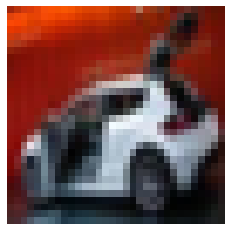

In [20]:
user.plot(true_user_data)

### Reconstruct user data:

Now we launch the attack, reconstructing user data based on only the `server_payload` and the `shared_data`. 

You can interrupt the computation early to see a partial solution.

In [21]:
reconstructed_user_data, stats = attacker.reconstruct([server_payload], [shared_data], {}, dryrun=cfg.dryrun)

| It: 1 | Rec. loss: 0.0156 |  Task loss: 2.3143 | T: 0.42s
| It: 101 | Rec. loss: 0.0028 |  Task loss: 2.3146 | T: 66.66s
| It: 201 | Rec. loss: 0.0045 |  Task loss: 2.3146 | T: 66.95s
| It: 301 | Rec. loss: 0.0040 |  Task loss: 2.3146 | T: 67.15s
| It: 400 | Rec. loss: 0.0044 |  Task loss: 2.3146 | T: 66.70s
Optimal candidate solution with rec. loss 0.0034 selected.


Next we'll evaluate metrics, comparing the `reconstructed_user_data` to the `true_user_data`.

In [22]:
metrics = breaching.analysis.report(reconstructed_user_data, true_user_data, [server_payload], 
                                    server.model, order_batch=True, compute_full_iip=False, 
                                    cfg_case=cfg.case, setup=setup)

Files already downloaded and verified
METRICS: | MSE: 0.0039 | PSNR: 24.06 | FMSE: 3.5066e-09 | LPIPS: 0.01|
 R-PSNR: 24.06 | IIP-pixel: 100.00% | SSIM: 0.8921 | max R-PSNR: 24.06 | max SSIM: 0.8921 | Label Acc: 100.00%


And finally, we also plot the reconstructed data:

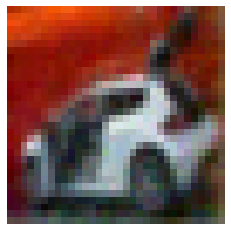

In [23]:
user.plot(reconstructed_user_data)

### Notes
* This is only the reconstruction part of the attack. They also propose a GAN-based refinement strategy which is not implemented here
* Neither CIFAR-10 or this model are used in the original paper. The model from the original paper can be retrieved with `case.model=convnet_beyond` and has an (even) larger fully-connected part than the default ConvNet used here.